# **CS 412 – Machine Learning Term Project**

# **Project Title:** Machine Learning Pipeline for Credit Risk Analysis with the German Credit Data
## **Group Members:**
### Ömer Said Öztürk - 26471
### Ahmet Mihça Aydın - 26753
### Göktuğ Korkulu - 27026
### Sadi Gülbey - 27047
### Musa Sadık Ünal - 28060


# Introduction

## Necesssary imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
from sklearn.model_selection import learning_curve

## Overview to Data

In [3]:
# German Credit data
df = pd.read_csv('german_credit_data.csv')

# if unnamed column, drop
df = df.drop('Unnamed: 0', axis=1)
X = df.iloc[:, :-1]
# Get dependent variable
y = (df.iloc[:, -1] == "good").astype(int)

In [4]:
from sklearn.preprocessing import OneHotEncoder
## Implementing one hot encoder
to_onehot = ["Sex", "Purpose"]

encoder = OneHotEncoder(handle_unknown='ignore')
encoded_data = encoder.fit_transform(X[to_onehot])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out())

X.drop(to_onehot, axis=1, inplace=True)
X = pd.concat([X, encoded_df], axis=1)

In [5]:
# A function that encodes columns with ordinal encoding
def ordinal_encode(X, column, order):
    sum = 0
    count = 0
    for i in range(X.shape[0]):
        if pd.isna(X[column][i]):
            continue
        sum += order.index(X[column][i])
        count += 1
        X.loc[i, column] = order.index(X[column][i])

    mean = sum / count
    for i in range(X.shape[0]):
        if pd.isna(X[column][i]):
            X.loc[i, column] = mean
    return X

In [6]:
# Apply ordinal encoding to necessary cols
to_ordinal = {
    "Housing": ["free", "rent", "own"],
    "Saving accounts": ["little", "moderate", "rich", "quite rich"],
    "Checking account": ["little", "moderate", "rich"]
}

X = ordinal_encode(X, "Housing", to_ordinal["Housing"])
X = ordinal_encode(X, "Saving accounts", to_ordinal["Saving accounts"])
X = ordinal_encode(X, "Checking account", to_ordinal["Checking account"])

In [7]:
from sklearn.preprocessing import MinMaxScaler

X_not_scaled = X.copy()
y_not_scaled = y.copy()
# min max scale each column
for column in X.columns:
    scaler = MinMaxScaler()
    X[column] = scaler.fit_transform(X[column].values.reshape(-1,1))

In [8]:
# divide dataset into three parts: train, validation, test with scikit
from sklearn.model_selection import train_test_split
# 80 Training - 20 Testing + Validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_not_scaled, y_not_scaled, test_size=0.10, random_state=42)

# Machine Learning Algorithms

## Helper function to use in single tries

In [9]:
# function to serialize validation
def foldAndValidate(model, X_train, y_train):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_accuracies = []

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    for train_index, val_index in kfold.split(X_train):
 
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]


        model.fit(X_train_fold, y_train_fold)

        fold_predictions = model.predict(X_val_fold)


        fold_accuracy = model.score(X_val_fold, y_val_fold)
        fold_accuracies.append(fold_accuracy)

        print("Accuracy for Fold:", fold_accuracy)

    # Calculate and print the average accuracy across all folds
    mean_accuracy = np.mean(fold_accuracies)
    print("Average Accuracy:", mean_accuracy)
    
    return mean_accuracy, fold_accuracies

In [10]:
# Taken from: https://gist.github.com/joseph-allen/9ada35224e617745ec0871a29b0df0ed and modified
import matplotlib.pyplot as plt
def plot_learning_curve(estimator, title, X, y, cv, train_sizes, train_scores, test_scores):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

## Logistic Regression Modal

In [11]:
from sklearn.linear_model import LogisticRegression
# Create a logistic regression model
model = LogisticRegression(max_iter=1000)

foldAndValidate(model, X_train, y_train)

Accuracy for Fold: 0.6777777777777778
Accuracy for Fold: 0.7277777777777777
Accuracy for Fold: 0.7055555555555556
Accuracy for Fold: 0.7
Accuracy for Fold: 0.6888888888888889
Average Accuracy: 0.7


(0.7,
 [0.6777777777777778,
  0.7277777777777777,
  0.7055555555555556,
  0.7,
  0.6888888888888889])

### Hyper-parameter selection of Logistic Regression Modal

In [12]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Create a logistic regression model
model = LogisticRegression()

penalty = ['l1', 'l2', 'elasticnet', 'none']
C = [0.1, 1, 10]
solver = [ 'liblinear', 'saga']
max_iter = [100, 500, 1000, 5000, 10000]

param_grid = {
    'penalty': penalty ,
    'C': C,
    'solver': solver,
    'max_iter': max_iter
}


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)


grid_search.fit(X_train_ns, y_train_ns)


print("Best Hyperparameters: ", grid_search.best_params_, "\nBest score: ", grid_search.best_score_)

warnings.filterwarnings("default")

Best Hyperparameters:  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'} 
Best score:  0.7144444444444444


### Plotting Logistic Regression Modal Hyper-parameters

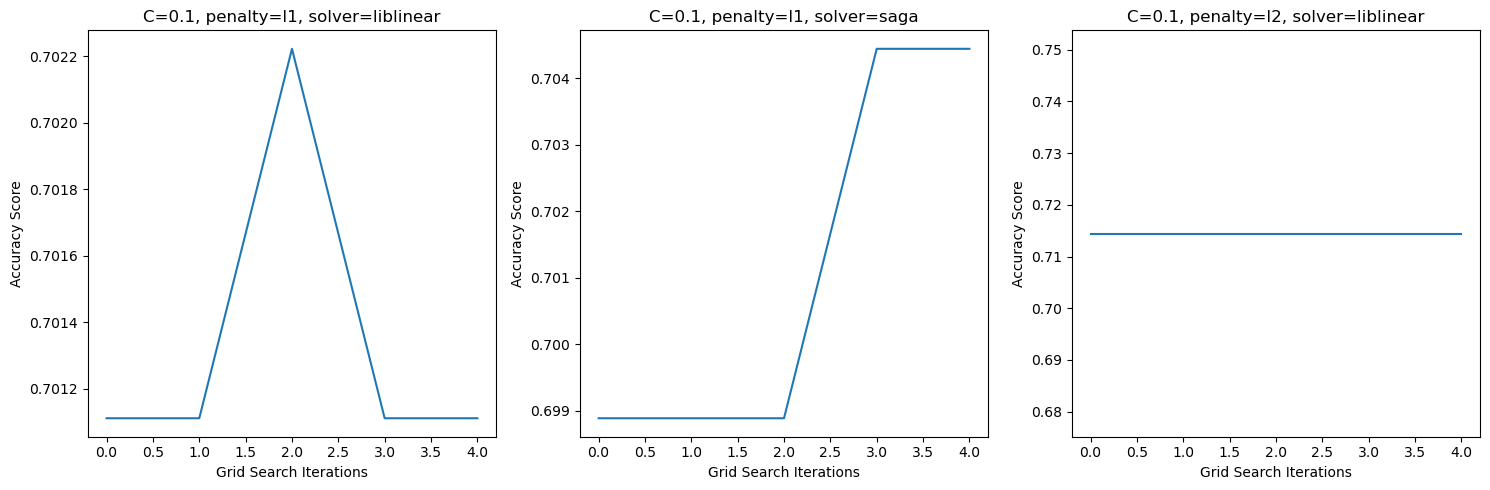

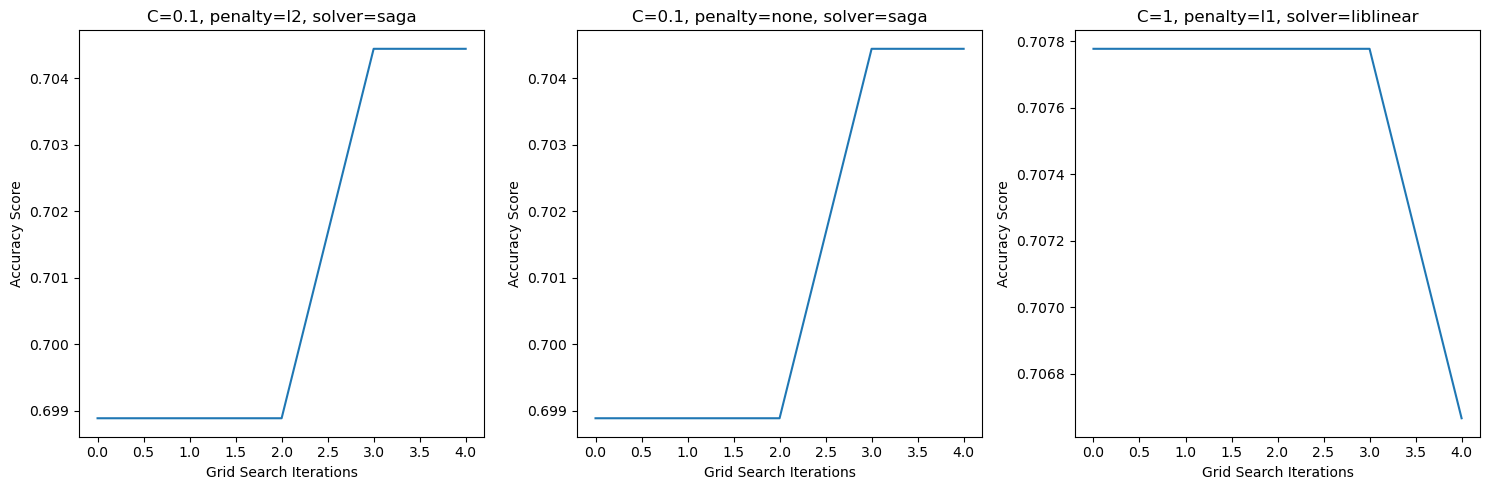

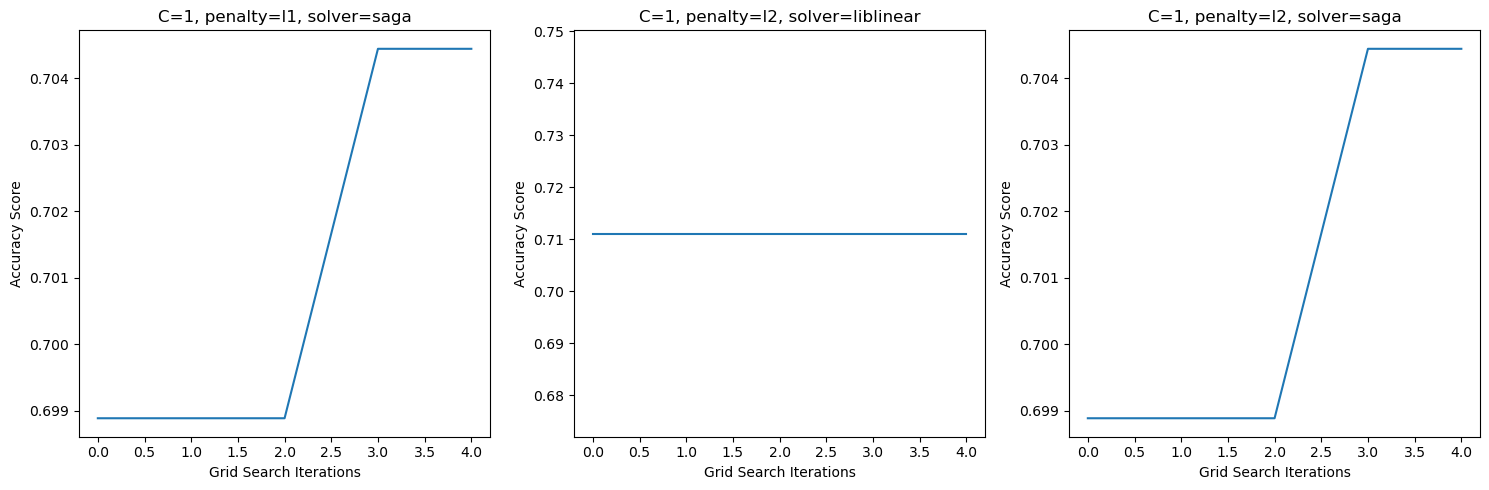

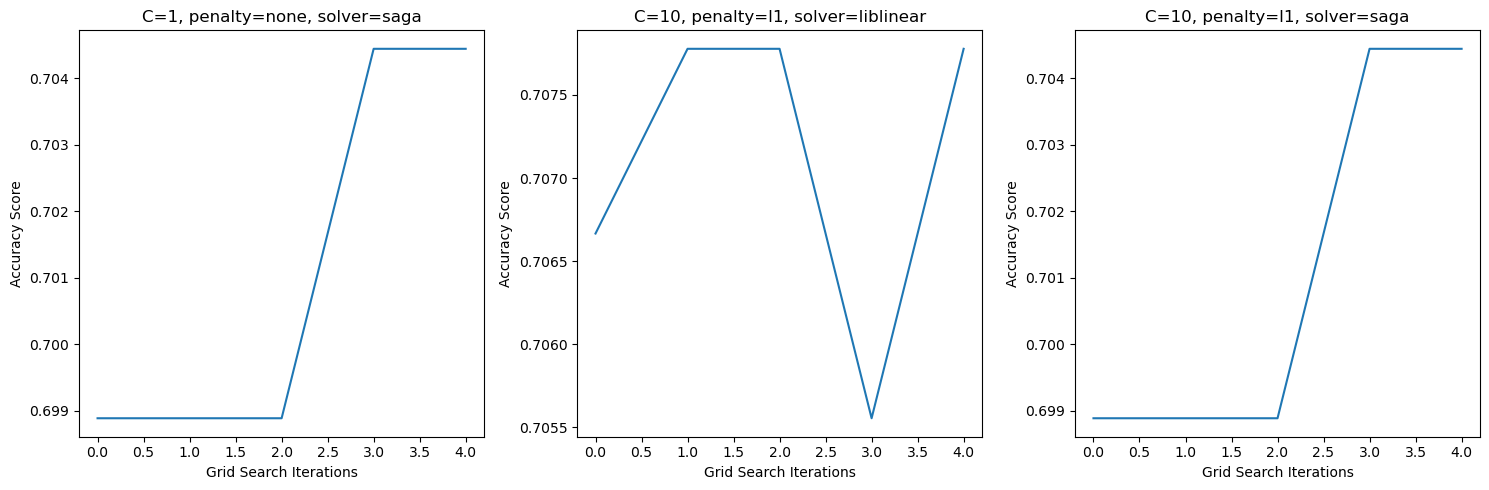

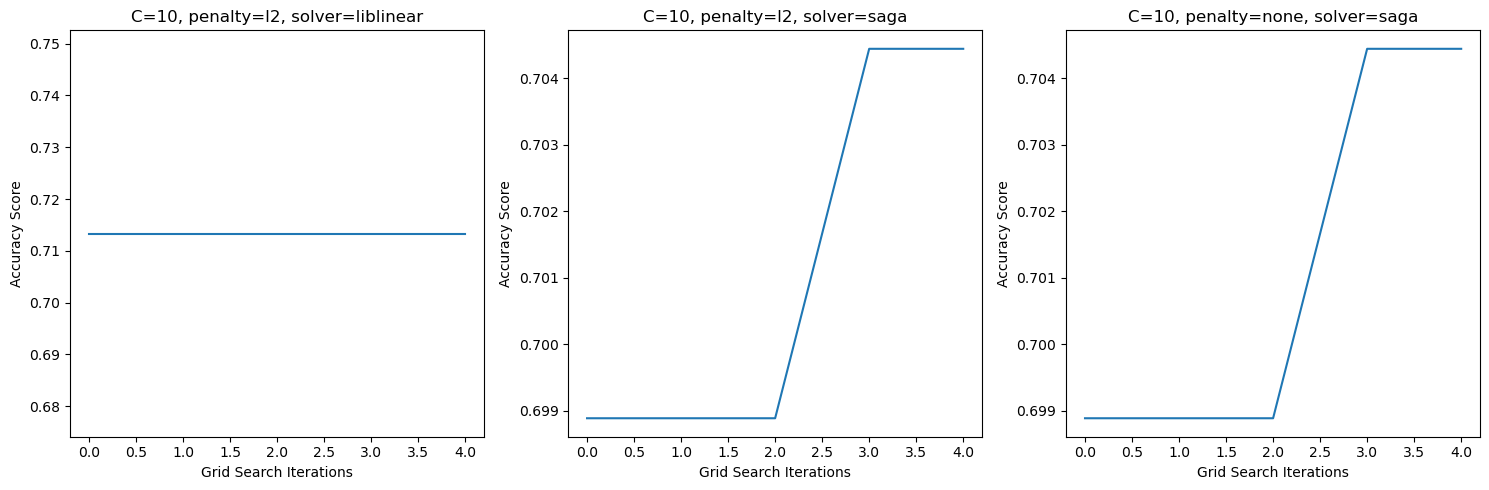

In [13]:
import matplotlib.pyplot as plt

# hyper parameter names and scores
names = list(grid_search.cv_results_['params'][0].keys())
scores = grid_search.cv_results_['mean_test_score']

values = [list(x.values()) for x in grid_search.cv_results_['params']]

values = np.array(values)
scores = np.array(scores)

c_idx = names.index('C')
penalty_idx = names.index('penalty')
solver_idx = names.index('solver')
max_iter_idx = names.index('max_iter')

c_values = np.unique(values[:, c_idx])
penalty_values = np.unique(values[:, penalty_idx])
solver_values = np.unique(values[:, solver_idx])

figure_counter = 0

# Plot the accuracy scores for each combination of hyperparameters
for c in c_values:
    for penalty in penalty_values:
        for solver in solver_values:

            mask = (values[:, c_idx] == c) & (
                values[:, penalty_idx] == penalty) & (values[:, solver_idx] == solver)
            max_iter_scores = scores[mask]
            if np.isnan(max_iter_scores).all():
                continue

            if figure_counter % 3 == 0:
                plt.figure(figsize=(15, 5))

            # Plot the accuracy scores in the current subplot
            plt.subplot(1, 3, (figure_counter % 3) + 1)
            plt.plot(max_iter_scores)
            plt.xlabel('Grid Search Iterations')
            plt.ylabel('Accuracy Score')
            plt.title(f'C={c}, penalty={penalty}, solver={solver}')

            # Increment the figure counter
            figure_counter += 1

            # Create a new row of figures after every three combinations
            if figure_counter % 3 == 0:
                plt.tight_layout()
                plt.show()

if figure_counter % 3 != 0:
    plt.tight_layout()
    plt.show()


## Decision Tree Classifier Modal

In [14]:
from sklearn.tree import DecisionTreeClassifier
# ignore iteration hyperparameter warnings
warnings.filterwarnings("ignore")

clf = DecisionTreeClassifier(random_state=42) 
foldAndValidate(clf, X_train, y_train)

warnings.filterwarnings("default")

Accuracy for Fold: 0.6666666666666666
Accuracy for Fold: 0.6444444444444445
Accuracy for Fold: 0.6611111111111111
Accuracy for Fold: 0.6611111111111111
Accuracy for Fold: 0.6611111111111111
Average Accuracy: 0.6588888888888889


### Decision Tree Modal Hyper Parameter selection

In [15]:
# Hyperparameter tuning
clf = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': np.arange(3, 10), 'criterion': ['gini', 'entropy']}

grid_clf = GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

print(f"Best parameters: {grid_clf.best_params_} {grid_clf.best_score_}")

Best parameters: {'criterion': 'entropy', 'max_depth': 5} 0.7066666666666667


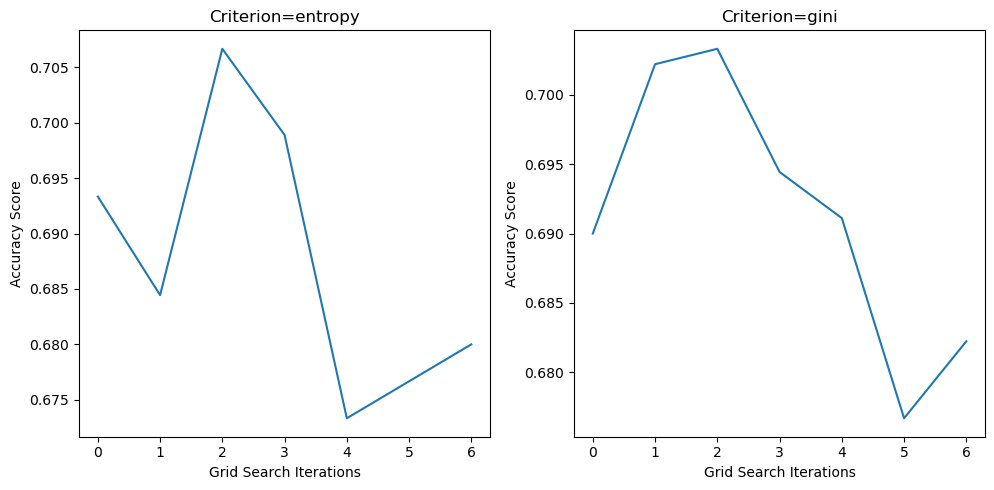

In [16]:
import matplotlib.pyplot as plt

names = list(grid_clf.cv_results_['params'][0].keys())
scores = grid_clf.cv_results_['mean_test_score']

values = [list(x.values()) for x in grid_clf.cv_results_['params']]

values = np.array(values)
scores = np.array(scores)

criterion_idx = names.index('criterion')
max_depth_idx = names.index('max_depth')

criterion_values = np.unique(values[:, criterion_idx])

figure_counter = 0

for c in criterion_values:
            mask = (values[:, criterion_idx] == c)
          
            max_depth_s = scores[mask]
            if np.isnan(max_depth_s).all():
                continue

            if figure_counter % 3 == 0:
                plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, (figure_counter % 3) + 1)
            plt.plot(max_depth_s)
            plt.xlabel('Grid Search Iterations')
            plt.ylabel('Accuracy Score')
            plt.title(f'Criterion={c}')
            figure_counter += 1

            if figure_counter % 3 == 0:
                plt.tight_layout()
                plt.show()


if figure_counter % 3 != 0:
    plt.tight_layout()
    plt.show()


## MLP Classifier Modal

We need to add `MLPClassifier` from `sklearn` library to use Multi-level Perceptron classifier.

In [17]:
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore")

mlp = MLPClassifier(random_state=42)
foldAndValidate(mlp, X_train, y_train)

warnings.filterwarnings("default")

Accuracy for Fold: 0.6722222222222223
Accuracy for Fold: 0.7055555555555556
Accuracy for Fold: 0.7055555555555556
Accuracy for Fold: 0.7222222222222222
Accuracy for Fold: 0.6944444444444444
Average Accuracy: 0.7


### MLP Classifier Hyper Parameter Selection

`MLPClassifier` includes several parameters which we can tune such as:
- hidden layer size
- activation function
- solver functions
- learning rate
- batch size 
- etc ...




In [18]:
import pandas  as pd


# choose hyperparameters using 5-fold cross validation
parameters = {  
                'hidden_layer_sizes': [(25,), (50,), (100,)],
                'solver': ['sgd', 'adam'],
                'alpha': [0.0001, 0.001],
                'activation':['relu', 'logistic'],
                'max_iter':[100]
              }

mlp = GridSearchCV(
      MLPClassifier(), 
      parameters, 
      cv=5,
      return_train_score=True)

Now search for best hyper-parameter and also get the learning curve. This process can take time.

In [19]:
warnings.filterwarnings("ignore")

mlp.fit(X_train, y_train)
mlp_train_sizes, mlp_train_scores, mlp_test_scores = learning_curve(mlp, X_train, y_train, cv=5)

warnings.filterwarnings("default")

These are best parameters:

In [ ]:
print(f"Best parameters: {mlp.best_params_} {mlp.best_score_}")

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'max_iter': 100, 'solver': 'adam'} 0.72


Now plot the learning curve.

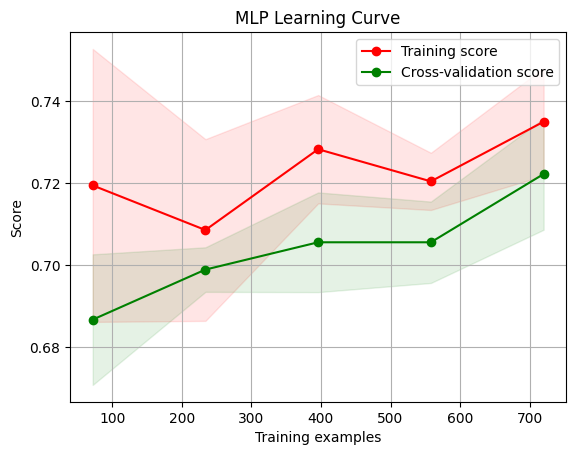

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# plot learning curve
plot_learning_curve(mlp, "MLP Learning Curve", X_train, y_train, 5, mlp_train_sizes, mlp_train_scores, mlp_test_scores)
plt.show()

### Network with Keras

We have also used Keras to create our model, since it is more flexible in terms of NN architecture and collecting accuracy-epoch information.

First let's add neccesseray packages.

In [ ]:
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import History 
import tensorflow as tf

warnings.filterwarnings("default")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We have tried with different architectures such as we tried with 2,3 hidden layers. However we achieve best results with only one hidden layer which 75% validation accuracy. Morever we used `binary_crossentropy` as loss function since we're trying to decide to give credit or not. We have used activation function same as upper code which is `relu`.

Moreover we added early stopping to avoid overfitting.

In [ ]:
input_dimension = 17 

nn_model = Sequential()
nn_model.add(Dense(80, input_dim=input_dimension, activation='relu'))
nn_model.add(Dense(1, activation='relu')) 

nn_model.compile(loss='binary_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

history = History()
stopper = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

warnings.filterwarnings("ignore")
nn_model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[history,stopper])
warnings.filterwarnings("default")

Epoch 1/150
29/29 [==============================] - 1s 9ms/step - loss: 2.8802 - accuracy: 0.3478 - val_loss: 0.9524 - val_accuracy: 0.4100
Epoch 2/150
29/29 [==============================] - 0s 4ms/step - loss: 0.8746 - accuracy: 0.4778 - val_loss: 0.7054 - val_accuracy: 0.5100
Epoch 3/150
29/29 [==============================] - 0s 4ms/step - loss: 0.7220 - accuracy: 0.6089 - val_loss: 0.6444 - val_accuracy: 0.6300
Epoch 4/150
29/29 [==============================] - 0s 4ms/step - loss: 0.6705 - accuracy: 0.6789 - val_loss: 0.6033 - val_accuracy: 0.6800
Epoch 5/150
29/29 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6944 - val_loss: 0.5974 - val_accuracy: 0.6900
Epoch 6/150
29/29 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6633 - val_loss: 0.6037 - val_accuracy: 0.6600
Epoch 7/150
29/29 [==============================] - 0s 4ms/step - loss: 0.6079 - accuracy: 0.6933 - val_loss: 0.5688 - val_accuracy: 0.7100
Epoch 8/150
2

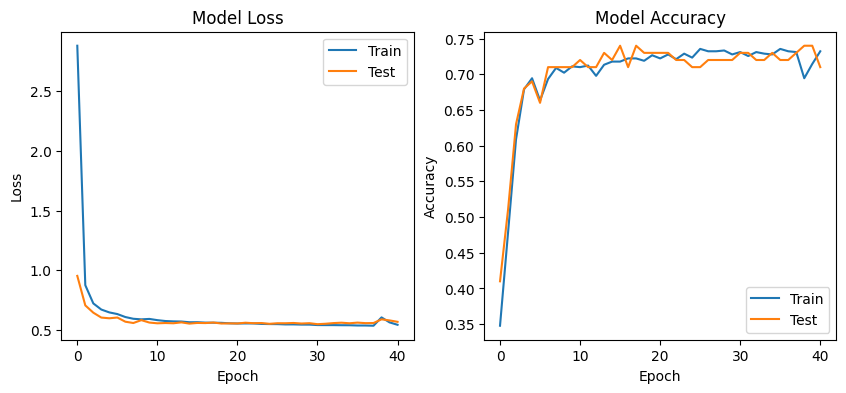

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Test'])

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Test'])

plt.show()

## KNN Modal

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=42)

### KNN Basic Modal

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

_ = foldAndValidate(knn, X_train, y_train)

Accuracy for Fold: 0.6666666666666666
Accuracy for Fold: 0.6722222222222223
Accuracy for Fold: 0.6888888888888889
Accuracy for Fold: 0.65
Accuracy for Fold: 0.6666666666666666
Average Accuracy: 0.6688888888888889


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### KNN Hyper-parameter selection

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_n = 0
best_accuracy = 0

accuracy_dict = {}

for n in [1,3,5,7,9,11,13]:
    print("n=", n)
    knn = KNeighborsClassifier(n_neighbors=n)
    average_accuracy,  fold_accuracies= foldAndValidate(knn, X_train, y_train)
    accuracy_dict[n] = fold_accuracies
    print("Average Accuracy: ", average_accuracy)
    if average_accuracy > best_accuracy:
        best_accuracy = average_accuracy
        best_n = n

print("Best n: ", best_n)

n= 1
Accuracy for Fold: 0.6555555555555556
Accuracy for Fold: 0.6444444444444445
Accuracy for Fold: 0.5833333333333334
Accuracy for Fold: 0.65
Accuracy for Fold: 0.6888888888888889
Average Accuracy: 0.6444444444444445
Average Accuracy:  0.6444444444444445
n= 3
Accuracy for Fold: 0.65
Accuracy for Fold: 0.6388888888888888
Accuracy for Fold: 0.6722222222222223
Accuracy for Fold: 0.6722222222222223
Accuracy for Fold: 0.6833333333333333
Average Accuracy: 0.6633333333333333
Average Accuracy:  0.6633333333333333
n= 5
Accuracy for Fold: 0.6111111111111112
Accuracy for Fold: 0.6888888888888889
Accuracy for Fold: 0.6833333333333333
Accuracy for Fold: 0.6666666666666666
Accuracy for Fold: 0.6777777777777778
Average Accuracy: 0.6655555555555555
Average Accuracy:  0.6655555555555555
n= 7
Accuracy for Fold: 0.6333333333333333
Accuracy for Fold: 0.6944444444444444
Accuracy for Fold: 0.6555555555555556
Accuracy for Fold: 0.6944444444444444
Accuracy for Fold: 0.6722222222222223
Average Accuracy: 0.670

## Plot for the hyperparameters


Text(0.5, 1.0, 'Mean and variance of accuracy for different n values')

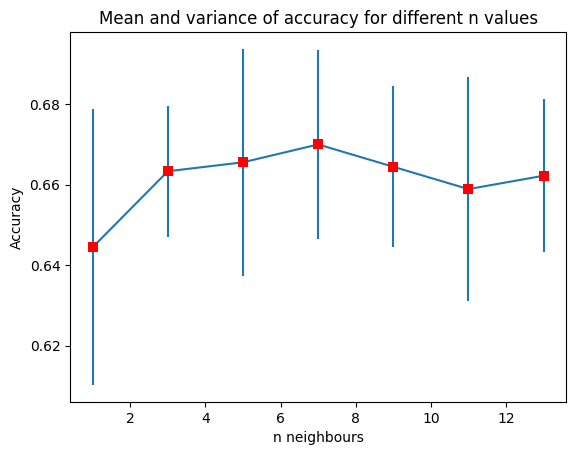

In [ ]:
import matplotlib.pyplot as plt
tops = {k:np.max(accuracy_dict[k]) for k in accuracy_dict.keys()}
bottoms = {k:np.min(accuracy_dict[k]) for k in accuracy_dict.keys()}

std_dict = {n:np.std(v) for n,v in accuracy_dict.items()}
mean_dict = {n:np.mean(v) for n,v in accuracy_dict.items()}

plt.errorbar(list(mean_dict.keys()), list(mean_dict.values()), list(std_dict.values()), marker='s', mfc='red', ms=7, mew=0)

plt.xlabel('n neighbours')
plt.ylabel('Accuracy')

plt.title("Mean and variance of accuracy for different n values")

## SVM Modal

### SVM Basic Modal

In [ ]:
# import SVM
from sklearn.svm import SVC

# Create a support vector machine model
svc = SVC(random_state = 42)

foldAndValidate(svc, X_train, y_train)

Accuracy for Fold: 0.6722222222222223
Accuracy for Fold: 0.7166666666666667
Accuracy for Fold: 0.75
Accuracy for Fold: 0.6888888888888889
Accuracy for Fold: 0.6555555555555556
Average Accuracy: 0.6966666666666665


(0.6966666666666665,
 [0.6722222222222223,
  0.7166666666666667,
  0.75,
  0.6888888888888889,
  0.6555555555555556])

### SVM Hyper-parameter Tuning

In [ ]:
# Hyper parameter tuning with svc
# Define an array of hyperparameter values
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best Score:  0.7133333333333333


## XGB Classifier

### XGB Classifier Basic Modal

In [ ]:
from xgboost import XGBClassifier

# Create a XGBClassifier model
xgb = XGBClassifier()

foldAndValidate(xgb, X_train, y_train)

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Accuracy for Fold: 0.7111111111111111
Accuracy for Fold: 0.7
Accuracy for Fold: 0.75
Accuracy for Fold: 0.7388888888888889
Accuracy for Fold: 0.6722222222222223
Average Accuracy: 0.7144444444444444


(0.7144444444444444,
 [0.7111111111111111, 0.7, 0.75, 0.7388888888888889, 0.6722222222222223])

### XGB Classifier Hyper-parameter Tuning

In [ ]:
# Grid search cv for xgb

# Define an array of hyperparameter values
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300, 400, 500]
}

# Perform grid search with 5-fold cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search_xgb.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_search_xgb.best_params_)
print("Best Score: ", grid_search_xgb.best_score_)


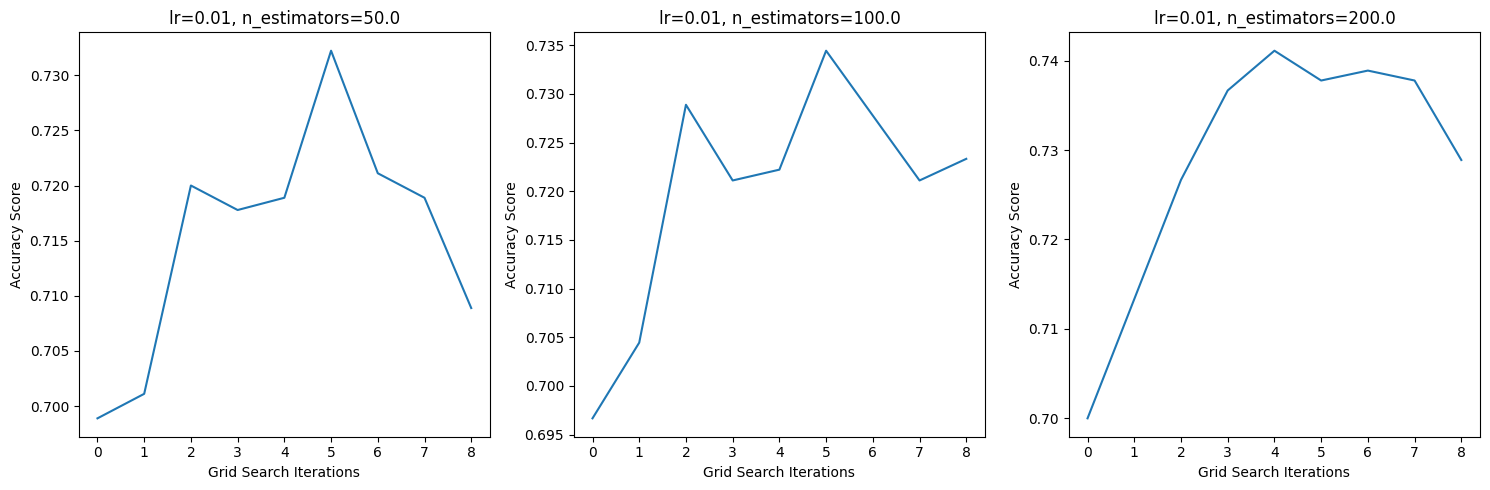

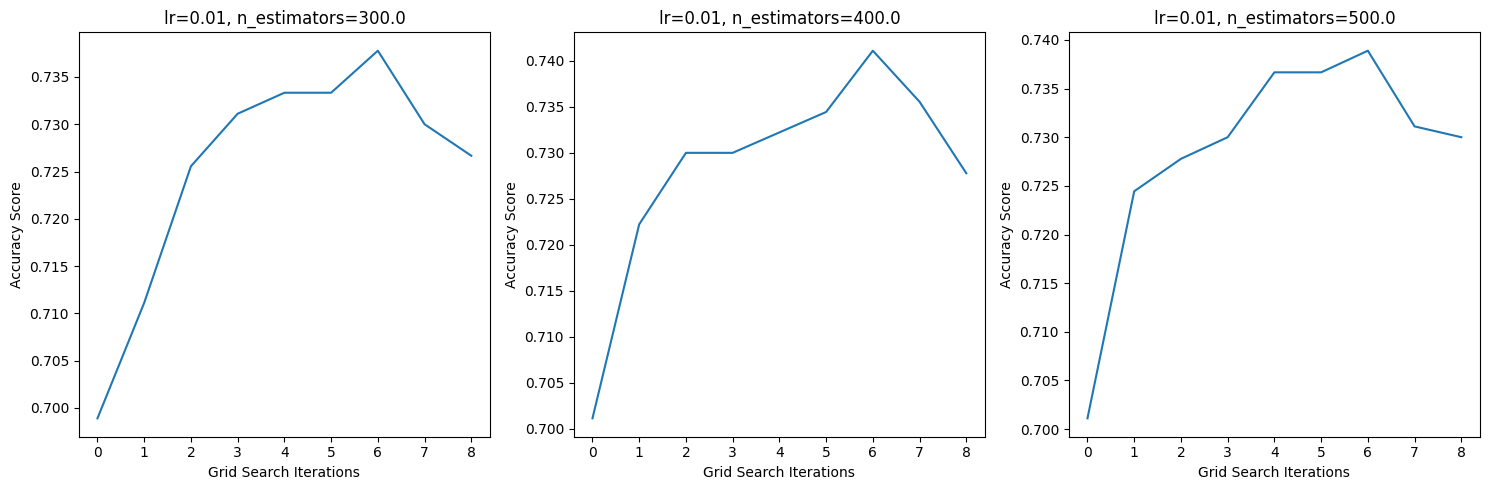

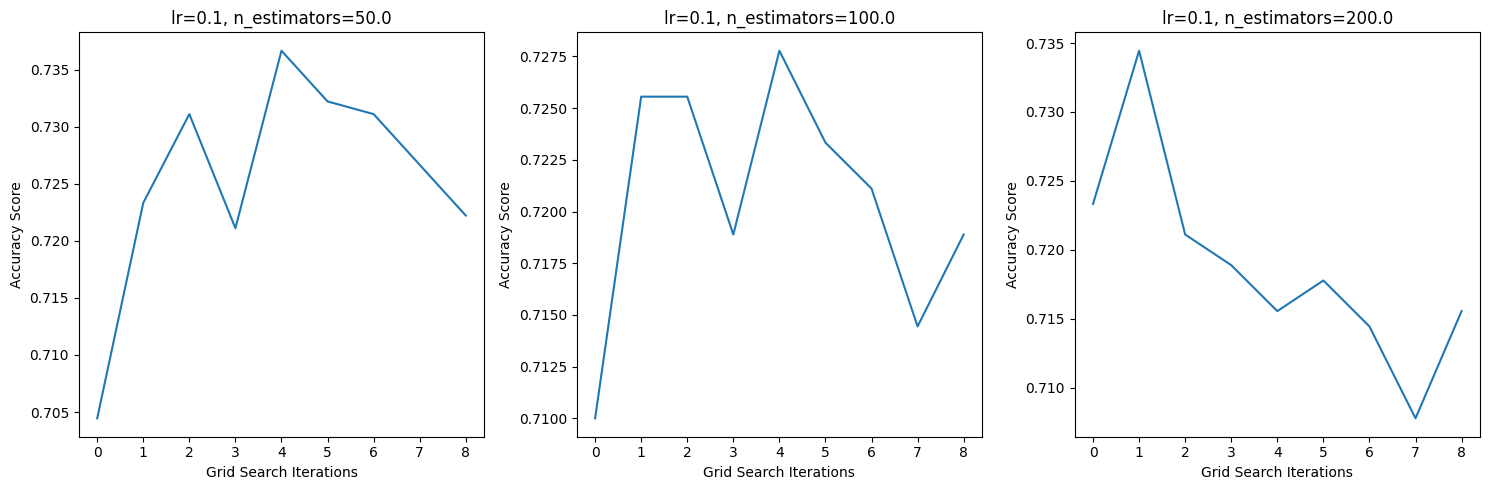

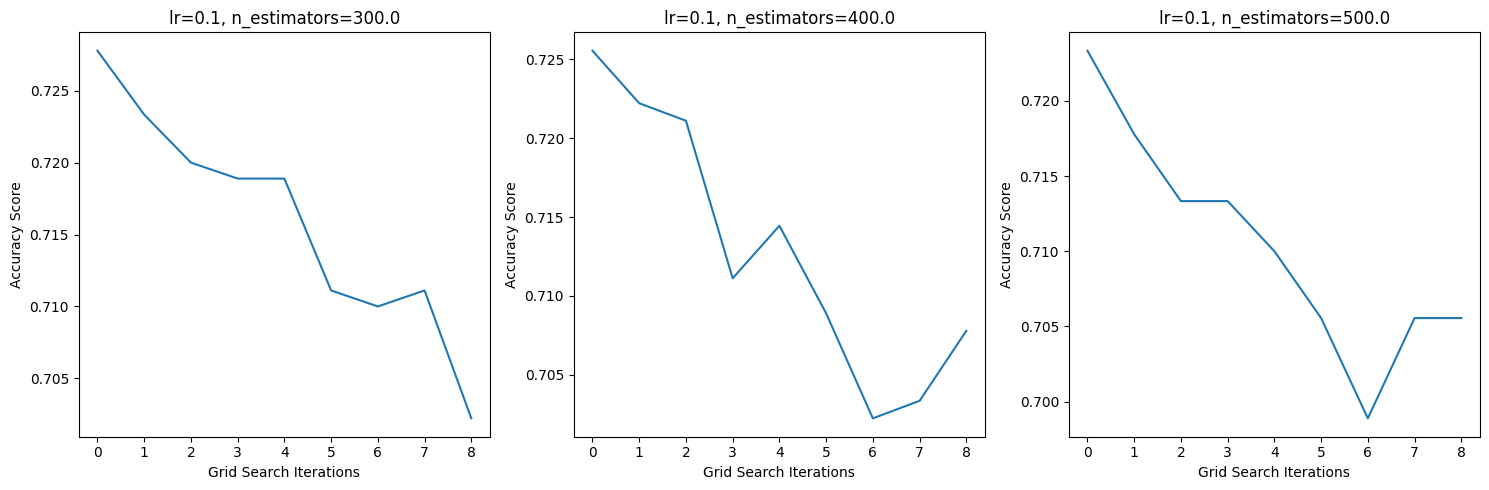

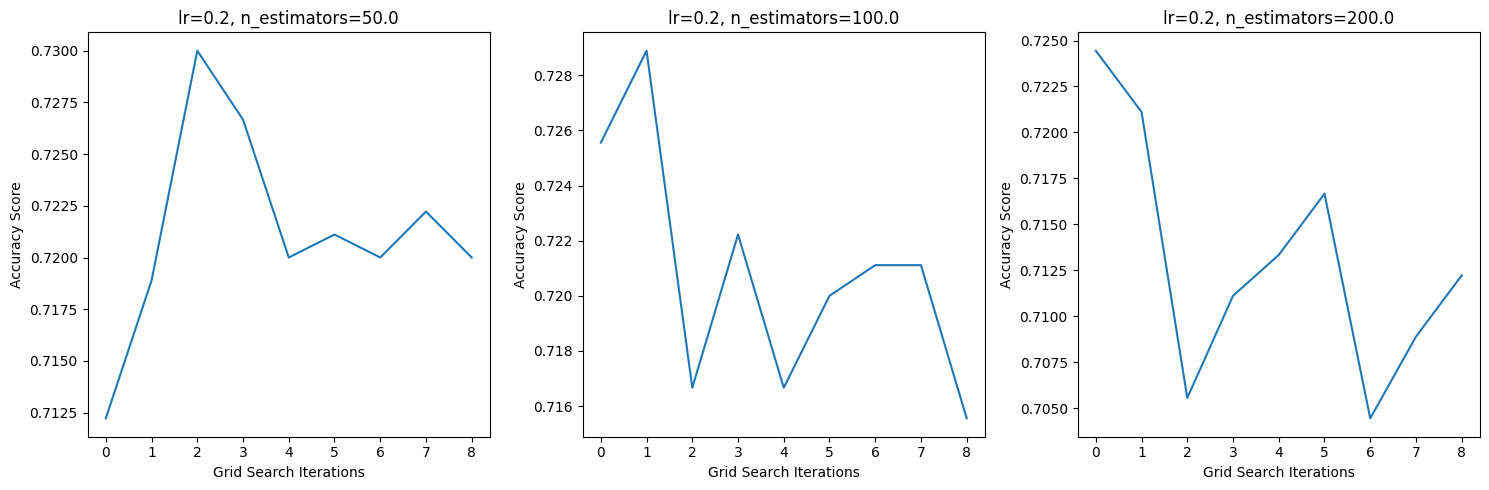

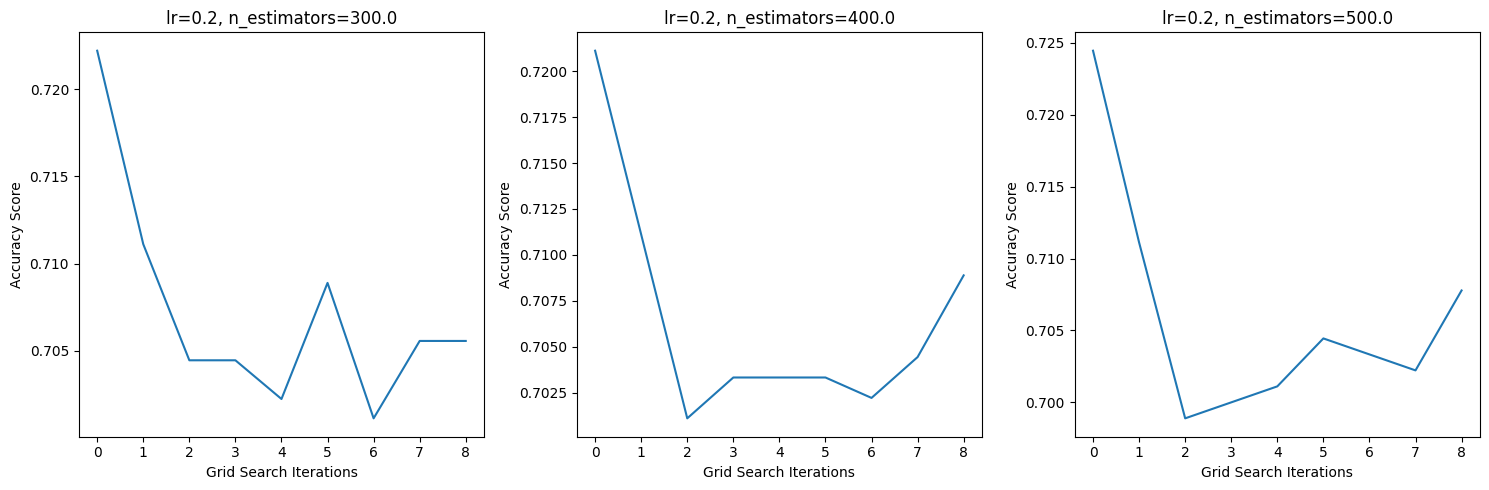

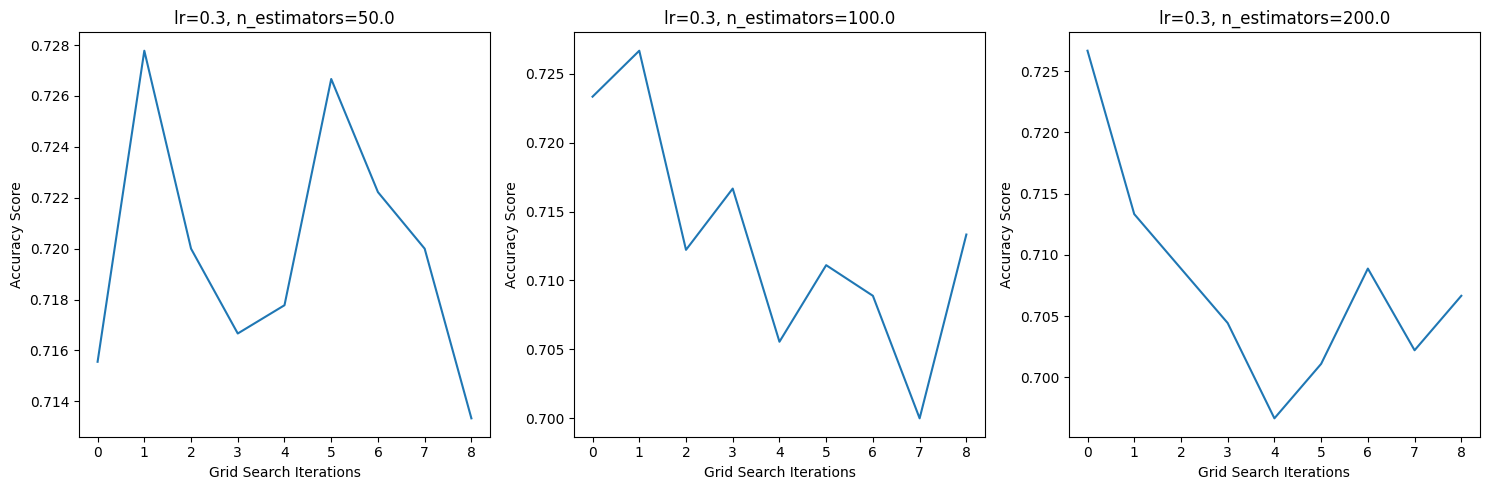

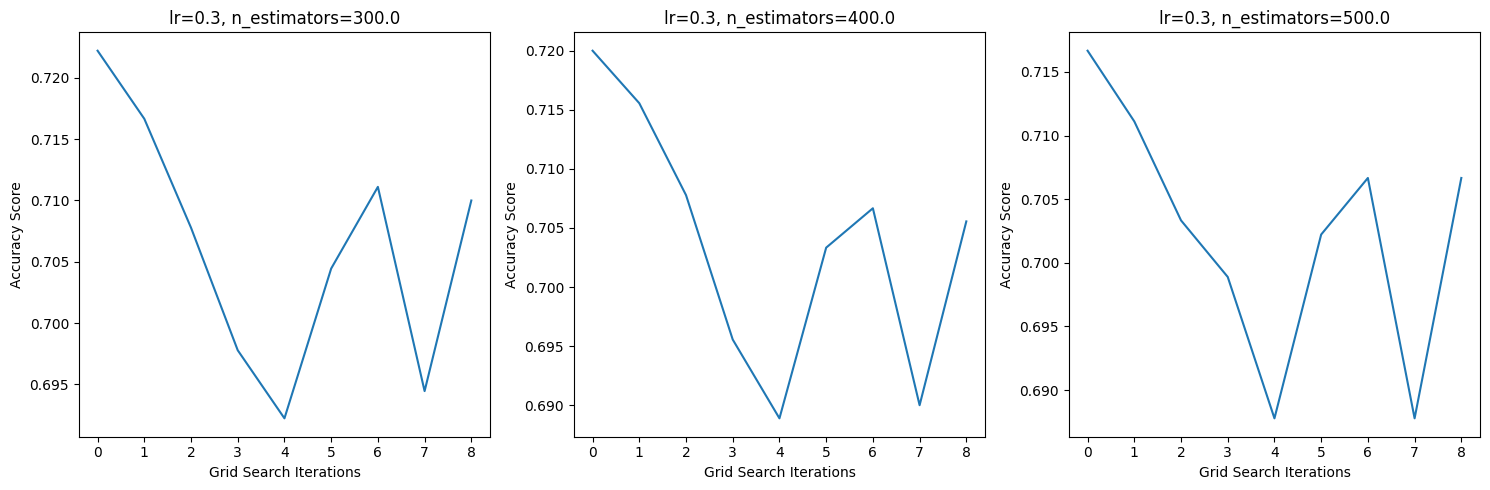

In [ ]:
import matplotlib.pyplot as plt

# Extract the hyperparameter names and scores from the grid search results
names = list(grid_search_xgb.cv_results_['params'][0].keys())
scores = grid_search_xgb.cv_results_['mean_test_score']

# Extract the parameter values for each hyperparameter
values = [list(x.values()) for x in grid_search_xgb.cv_results_['params']]

# Convert the parameter values and scores to numpy arrays
values = np.array(values)
scores = np.array(scores)

# Get the indices of the hyperparameters
lr_idx = names.index('learning_rate')
n_estimators_idx = names.index('n_estimators')
max_depth_idx = names.index('max_depth')

# Extract the unique values of each hyperparameter
lr_values = np.unique(values[:, lr_idx])
n_estimators_values = np.unique(values[:, n_estimators_idx])


# Create a counter for figures
figure_counter = 0

# Plot the accuracy scores for each combination of hyperparameters
for c in lr_values:
    for n_estimators in n_estimators_values:

            mask = (values[:, lr_idx] == c) & (
                values[:, n_estimators_idx] == n_estimators)
            max_depth_scores = scores[mask]
            if np.isnan(max_depth_scores).all():
                continue

            # Create a new figure every three combinations
            if figure_counter % 3 == 0:
                plt.figure(figsize=(15, 5))

            # Plot the accuracy scores in the current subplot
            plt.subplot(1, 3, (figure_counter % 3) + 1)
            plt.plot(max_depth_scores)
            plt.xlabel('Grid Search Iterations')
            plt.ylabel('Accuracy Score')
            plt.title(f'lr={c}, n_estimators={n_estimators}')

            # Increment the figure counter
            figure_counter += 1

            # Create a new row of figures after every three combinations
            if figure_counter % 3 == 0:
                plt.tight_layout()
                plt.show()

# If the last row does not contain three figures, show the remaining figures
if figure_counter % 3 != 0:
    plt.tight_layout()
    plt.show()

In [ ]:
xgb_train_sizes, xgb_train_scores, xgb_test_scores = learning_curve(grid_search, X_train, y_train, cv=5)

In [ ]:
plot_learning_curve(grid_search, "Logistic Regression Learning Curve", X_train, y_train, 5, xgb_train_sizes, xgb_train_scores, xgb_test_scores)

## Test the Best Performing modal

In [ ]:
from xgboost import XGBClassifier

# Create a XGBClassifier model
xgb = XGBClassifier(learning_rate =  0.01, max_depth = 5, n_estimators=  200)

xgb.fit(X_train, y_train)

accuracy_score(y_test, xgb.predict(X_test))

0.79

## Bonus: Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create a logistic regression model
logistic_regression = LogisticRegression(C = 0.1, max_iter =  1000, penalty =  'l2', solver = 'liblinear')

# Create a support vector machine model
svc = SVC(C = 1, gamma = "scale", kernel = "poly")

# Create a decision tree model
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth = 5)

# Create a KNN model
knn = KNeighborsClassifier(n_neighbors = 5)

# Create a mlp model
mlp = MLPClassifier(activation =  'logistic', alpha= 0.0001, batch_size =  70, hidden_layer_sizes= (96, 96, 96, 96, 96), max_iter= 1000)

# Create a xgb model
xgb = XGBClassifier(learning_rate =  0.01, max_depth = 5, n_estimators=  200)
# Create a voting classifier model
voting_classifier = VotingClassifier(
    estimators=[('lr', logistic_regression), ('dt', decision_tree),('xgb', xgb) ,('mlp', mlp)], voting='hard', weights=[1,1,1,1])

foldAndValidate(voting_classifier, X_train, y_train)


Accuracy for Fold: 0.7388888888888889
Accuracy for Fold: 0.75
Accuracy for Fold: 0.7555555555555555
Accuracy for Fold: 0.7555555555555555
Accuracy for Fold: 0.7277777777777777
Average Accuracy: 0.7455555555555555


(0.7455555555555555,
 [0.7388888888888889,
  0.75,
  0.7555555555555555,
  0.7555555555555555,
  0.7277777777777777])

In [ ]:
voting_classifier.fit(X_train, y_train)

accuracy_score(y_test, voting_classifier.predict(X_test))

0.73

## Bonus: Mixture of Experts

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MixtureOfExperts(BaseEstimator, ClassifierMixin):
    def __init__(self, expert_models, gating_model):
        self.expert_models = expert_models  
        self.gating_model = gating_model  
    
    def fit(self, X, y):
      
        for model in self.expert_models:
            foldAndValidate(model, X, y)

        expert_predictions = np.array([model.predict_proba(X)[:, 1] for model in self.expert_models]).T
        gating_data = expert_predictions
   
        foldAndValidate(gating_model, expert_predictions, y)
        return self
    
    def predict(self, X):
        # Get predictions from expert models
        expert_predictions = np.array([model.predict_proba(X)[:, 1] for model in self.expert_models]).T
        gating_data = expert_predictions
        
        return self.gating_model.predict(gating_data)
    

expert_models = [
    SVC(C= 1, gamma=  'scale', kernel =  'poly',probability = True),
    KNeighborsClassifier(n_neighbors=  5),
    DecisionTreeClassifier(criterion='entropy', max_depth = 5),
    LogisticRegression(C = 0.1, max_iter =  1000, penalty =  'l2', solver = 'liblinear'),
    MLPClassifier(activation =  'logistic', alpha= 0.0001, batch_size =  70, hidden_layer_sizes= (96, 96, 96, 96, 96), max_iter= 1000),
    XGBClassifier(learning_rate =  0.01, max_depth = 5, n_estimators=  200),
]
gating_model = LogisticRegression(C = 0.1, max_iter = 1000)

moe = MixtureOfExperts(expert_models=expert_models, gating_model=gating_model)

moe.fit(X_train,y_train)

preds = moe.predict(X_test)

accuracy_score(y_test, preds)

Accuracy for Fold: 0.6777777777777778
Accuracy for Fold: 0.7
Accuracy for Fold: 0.6944444444444444
Accuracy for Fold: 0.6833333333333333
Accuracy for Fold: 0.6833333333333333
Average Accuracy: 0.6877777777777778
Accuracy for Fold: 0.6666666666666666
Accuracy for Fold: 0.6666666666666666
Accuracy for Fold: 0.7222222222222222
Accuracy for Fold: 0.65
Accuracy for Fold: 0.6722222222222223
Average Accuracy: 0.6755555555555555
Accuracy for Fold: 0.6611111111111111
Accuracy for Fold: 0.7333333333333333
Accuracy for Fold: 0.6888888888888889
Accuracy for Fold: 0.7666666666666667
Accuracy for Fold: 0.7222222222222222
Average Accuracy: 0.7144444444444444
Accuracy for Fold: 0.6777777777777778
Accuracy for Fold: 0.7277777777777777
Accuracy for Fold: 0.7555555555555555
Accuracy for Fold: 0.7
Accuracy for Fold: 0.6666666666666666
Average Accuracy: 0.7055555555555555
Accuracy for Fold: 0.6833333333333333
Accuracy for Fold: 0.7166666666666667
Accuracy for Fold: 0.7388888888888889
Accuracy for Fold: 0.6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python

0.77

## Random Forest Classifier


In [ ]:
# do random forest

from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier model
rf = RandomForestClassifier()

foldAndValidate(rf, X_train, y_train)


Accuracy for Fold: 0.7
Accuracy for Fold: 0.7
Accuracy for Fold: 0.7555555555555555
Accuracy for Fold: 0.7833333333333333
Accuracy for Fold: 0.6888888888888889
Average Accuracy: 0.7255555555555555


(0.7255555555555555,
 [0.7, 0.7, 0.7555555555555555, 0.7833333333333333, 0.6888888888888889])

In [ ]:
# grid search cv for random forest

# Define an array of hyperparameter values
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Hyperparameters:  {'max_depth': 9, 'n_estimators': 200}
Best Score:  0.7300000000000001
